# Uncofoundedness

We call 'Uncofoundedness' a scenario where a treatment is not randomly assigned to participants, so confounders effect on treatment assignment and outcome.

Treatment - purchase in one category.

We will test hypothesis:

$H_o$ - There is no difference in LTV between treatment and control groups.

$H_a$ - There is a difference in LTV between treatment and control groups.

In [1]:
from causalis.scenarios.unconfoundedness.dgp import generate_obs_hte_26

data = generate_obs_hte_26(return_causal_data=False, include_oracle=True)
data.head()


,y,d,tenure_months,avg_sessions_week,spend_last_month,premium_user,urban_resident,m,m_obs,tau_link,g0,g1,cate
0,-1.983895,1.0,28.814654,1.0,84.100761,1.0,0.0,0.452856,0.452856,0.851367,2.719917,3.571283,0.851367
1,7.527126,0.0,7.444181,0.0,30.890847,0.0,1.0,0.262168,0.262168,0.441365,2.712251,3.153617,0.441365
2,6.696842,1.0,23.759279,2.0,93.693180,0.0,0.0,0.346111,0.346111,0.610918,1.552879,2.163797,0.610918
3,10.337161,0.0,24.969929,9.0,127.974978,0.0,1.0,0.438569,0.438569,1.370303,2.509991,3.880294,1.370303
4,6.071955,0.0,29.943261,2.0,96.998539,0.0,1.0,0.403751,0.403751,0.651407,2.531525,3.182932,0.651407


In [2]:
print(f"Ground truth ATE is {data['cate'].mean()}")
print(f"Ground truth ATTE is {data[data['d'] == 1]['cate'].mean()}")

Ground truth ATE is 0.9509353818962032
Ground truth ATTE is 1.0477490564692595


In [3]:
from causalis.data_contracts import CausalData

causaldata = CausalData(df = data,
                        treatment='d',
                        outcome='y',
                        confounders=['tenure_months', 'avg_sessions_week', 'premium_user', 'urban_resident'])
causaldata

CausalData(df=(10000, 6), treatment='d', outcome='y', confounders=['tenure_months', 'avg_sessions_week', 'premium_user', 'urban_resident'])

In [4]:
from causalis.shared import outcome_stats
outcome_stats(causaldata)

,treatment,count,mean,std,min,p10,p25,median,p75,p90,max
0,0.0,6546,2.323022,3.633758,-10.176002,-2.316158,-0.083891,2.301122,4.769961,7.054387,14.896189
1,1.0,3454,3.674711,3.717209,-8.675591,-1.099642,1.151377,3.723854,6.154913,8.441785,17.236140


(<Figure size 1540x880 with 1 Axes>, <Figure size 1540x880 with 1 Axes>)

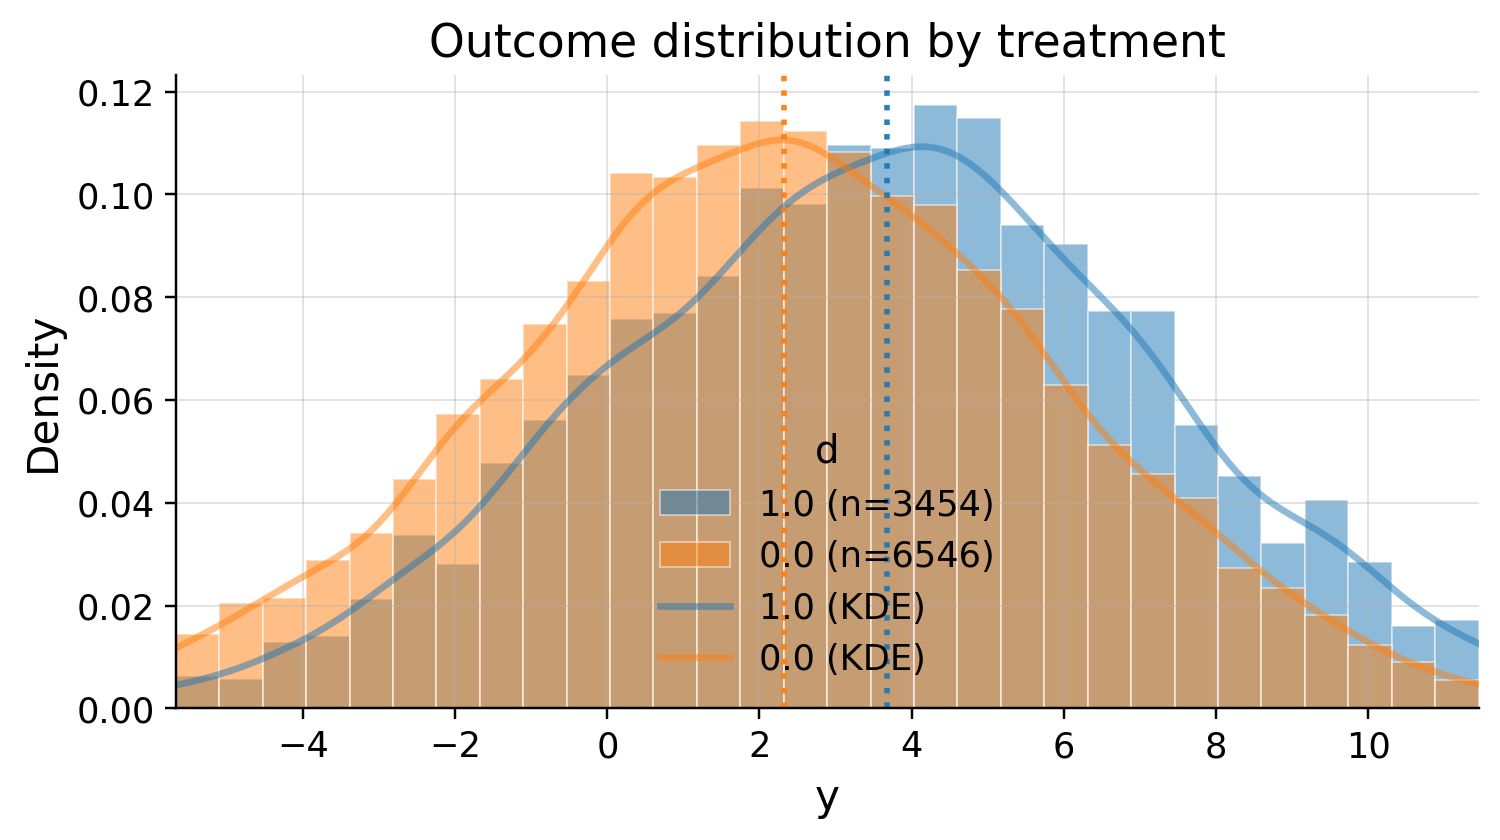

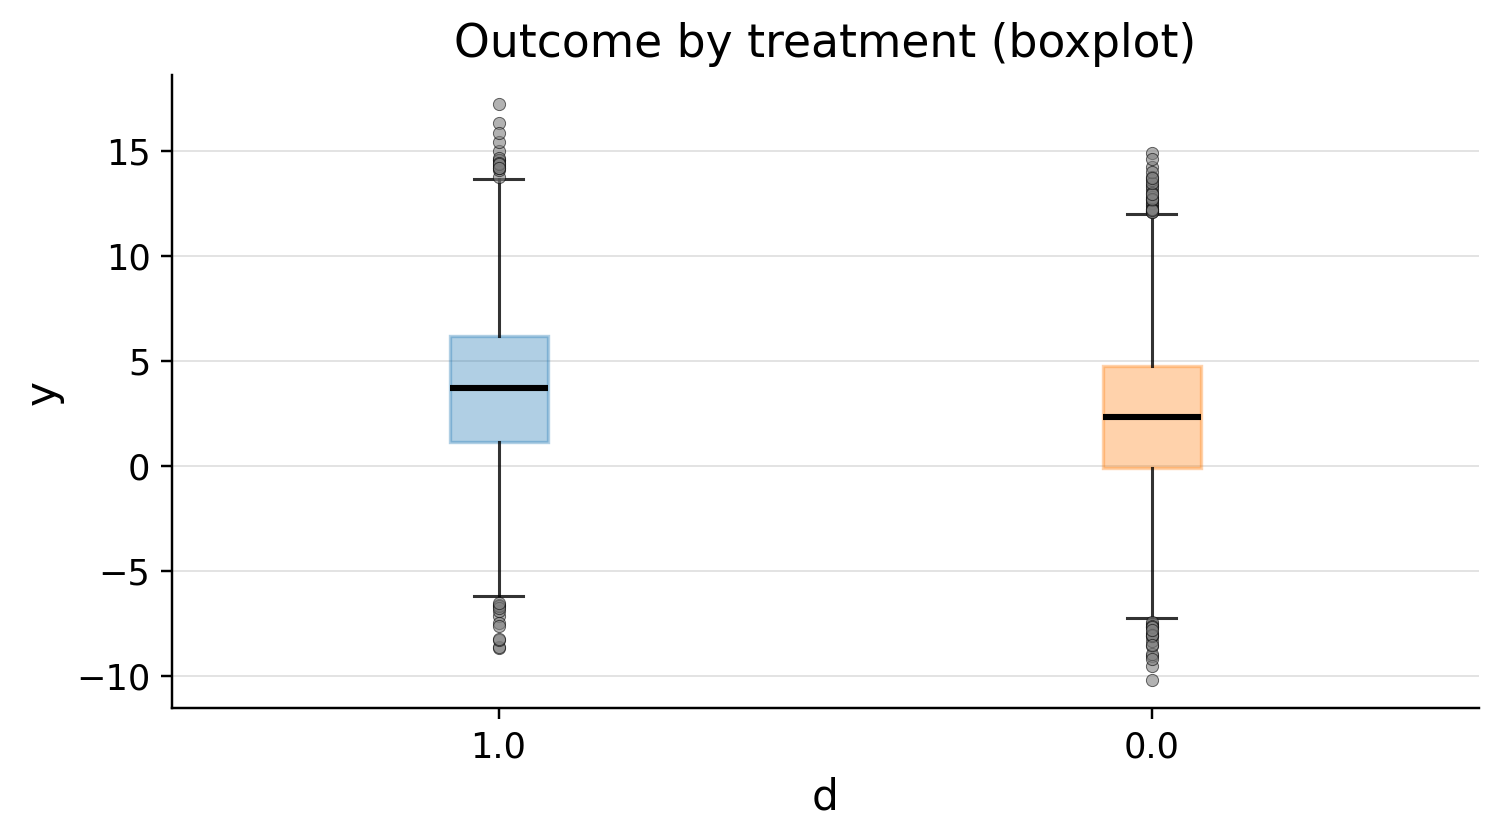

In [5]:
from causalis.shared import outcome_plots
outcome_plots(causaldata)

In [6]:
from causalis.scenarios.unconfoundedness import IRM

model = IRM().fit(causaldata)

### Math Explanation of the IRM Model and ATTE Estimand

The **Interactive Regression Model (IRM)** is a flexible framework used in Double Machine Learning (DML) to estimate treatment effects. Unlike linear models, it allows the treatment effect to vary with confounders $X$ (interaction) and makes no parametric assumptions about the functional forms of the outcomes.


#### 1. Nuisance Functions
The IRM framework relies on three "nuisance" components estimated from the data:
*   **Outcome Regression (Control):** $g_0(X) = \mathbb{E}[Y | X, D=0]$
*   **Outcome Regression (Treated):** $g_1(X) = \mathbb{E}[Y | X, D=1]$
*   **Propensity Score:** $m(X) = \mathbb{P}(D=1 | X)$

In the provided implementation (`irm.py`), these are estimated using cross-fitting (splitting data into folds) to avoid overfitting bias.


#### 2. ATTE (Average Treatment Effect on the Treated)
The **Average Treatment Effect on the Treated (ATTE)** measures the impact of the treatment specifically on those individuals who received it:
$$\theta_{ATTE} = \mathbb{E}[Y(1) - Y(0) \mid D=1]$$
Under the assumption of **unconfoundedness** (no hidden confounders), this can be identified from observable data.


#### 3. The Orthogonal Score
DML uses a **Neyman-orthogonal score** $\psi$ to ensure the estimator is robust to small errors in the nuisance function estimates. The score for ATTE is defined as:
$$\psi(W; \theta, \eta) = \psi_b(W; \eta) + \psi_a(W; \eta)\theta$$

Based on the implementation in `irm.py`, the components are:
*   **Linear component:** $\psi_a(W; \eta) = -\frac{D}{\mathbb{P}(D=1)}$
*   **Residual component:** $\psi_b(W; \eta) = \frac{D(Y - g_0(X))}{\mathbb{P}(D=1)} - \frac{m(X)(1-D)(Y - g_0(X))}{\mathbb{P}(D=1)(1 - m(X))}$

Where:
*   $D$ is the binary treatment indicator.
*   $Y$ is the observed outcome.
*   $\mathbb{P}(D=1)$ is the probability of treatment (estimated as the mean of $D$).


#### 4. Final Estimation
The estimate $\hat{\theta}_{ATTE}$ is obtained by solving the moment condition $\mathbb{E}[\psi(W; \theta, \eta)] = 0$:
$$\hat{\theta}_{ATTE} = \frac{\mathbb{E}[\psi_b(W; \eta)]}{\mathbb{E}[-\psi_a(W; \eta)]}$$

Since $\mathbb{E}[-\psi_a] = \mathbb{E}\left[\frac{D}{\mathbb{P}(D=1)}\right] = 1$, the estimand simplifies to the expectation of the doubly robust residual $\psi_b$. Note that for ATTE, the term $g_1(X)$ cancels out during simplification, making the estimate primarily dependent on the control group's outcome model $g_0(X)$ and the propensity score $m(X)$.

In [7]:
result = model.estimate(score='ATTE')
result.summary()

,estimand,coefficient,p_val,lower_ci,upper_ci,relative_diff_%,is_significant
0,ATTE,1.127008,0.0,0.955959,1.298056,44.082745,True


In [8]:
result

CausalEstimate(estimand='ATTE', model='IRM', model_options={'n_folds': 5, 'n_rep': 1, 'normalize_ipw': False, 'trimming_rule': 'truncate', 'trimming_threshold': 0.01, 'random_state': None, 'std_error': 0.08727146970637431, 't_stat': 12.91381383789221}, value=1.1270075131473674, ci_upper_absolute=1.2980564506497394, ci_lower_absolute=0.9559585756449953, value_relative=44.082745240547645, ci_upper_relative=50.77330111317513, ci_lower_relative=37.39218936792015, alpha=0.05, p_value=0.0, is_significant=True, n_treated=3454, n_control=6546, outcome='y', treatment='d', confounders=['tenure_months', 'avg_sessions_week', 'premium_user', 'urban_resident'], time=datetime.datetime(2026, 1, 18, 19, 16, 51, 804711), diagnostic_data=UnconfoundednessDiagnosticData(m_hat=array([0.34885668, 0.3092771 , 0.28481018, ..., 0.3113148 , 0.56291757,
       0.35536874], shape=(10000,)), d=array([1, 0, 1, ..., 1, 1, 0], shape=(10000,)), y=array([-1.98389494,  7.52712572,  6.69684196, ..., -5.67407368,
        6

In [9]:
from causalis.scenarios.unconfoundedness.refutation import *
rep = run_overlap_diagnostics(res=result)
rep["summary"]

,metric,value,flag
0,edge_0.01_below,0.000000,GREEN
1,edge_0.01_above,0.000000,GREEN
2,edge_0.02_below,0.000000,GREEN
3,edge_0.02_above,0.000000,GREEN
4,KS,0.152121,GREEN
5,AUC,0.595822,GREEN
6,ESS_treated_ratio,0.872813,GREEN
7,ESS_control_ratio,0.936851,GREEN
8,tails_w1_q99/med,3.813884,GREEN
9,tails_w0_q99/med,3.699759,GREEN


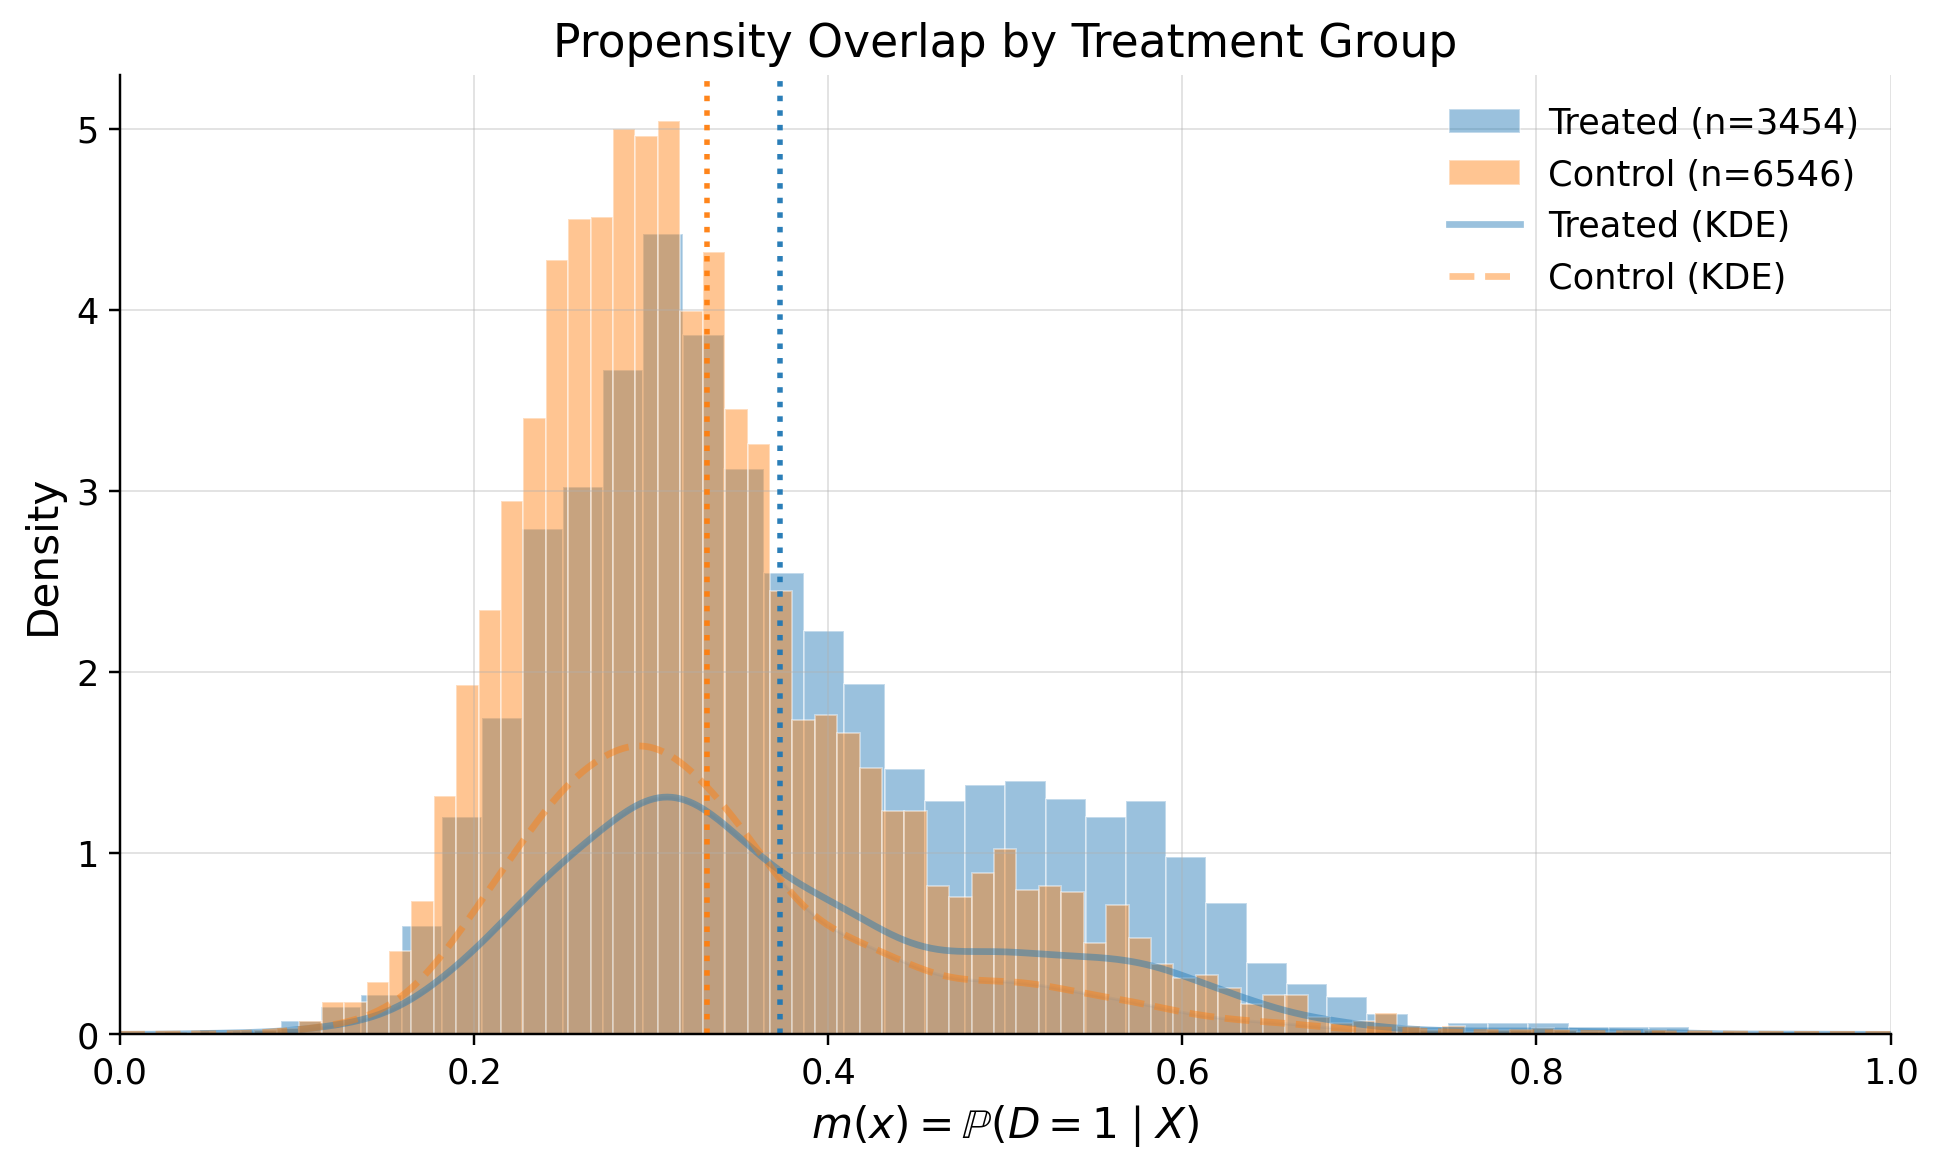

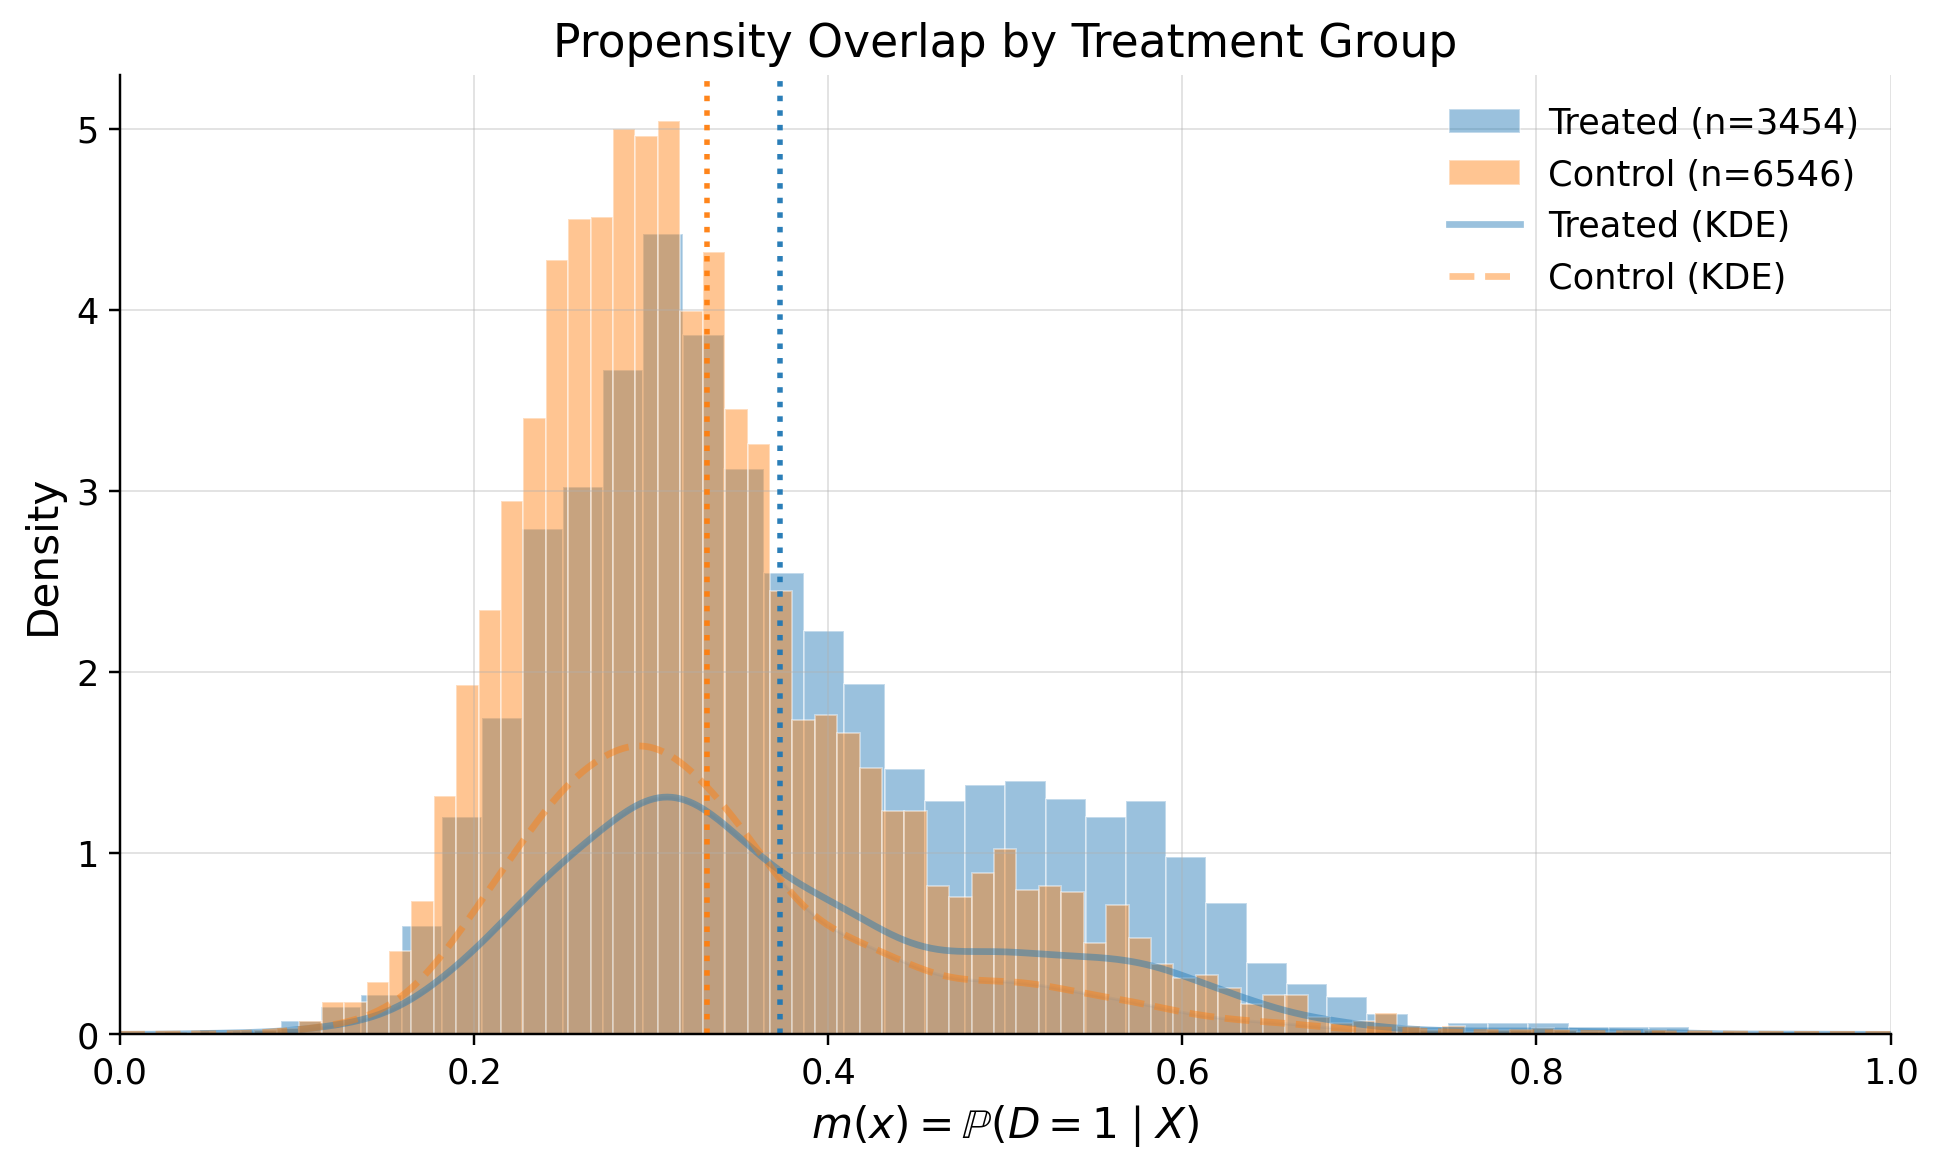

In [10]:
plot_m_overlap(result.diagnostic_data)

In [11]:
from causalis.scenarios.unconfoundedness.refutation.score.score_validation import run_score_diagnostics
rep_score = run_score_diagnostics(res=result)
rep_score["summary"]

,metric,value,flag
0,se_plugin,0.087271,NA
1,psi_p99_over_med,6.470707,GREEN
2,psi_kurtosis,32.692588,RED
3,max_|t|_g1,0.000000,GREEN
4,max_|t|_g0,2.105126,YELLOW
5,max_|t|_m,0.168875,GREEN


In [12]:
print_sutva_questions()

1.) Are your clients independent (i)?
2.) Do you measure confounders, treatment, and outcome in the same intervals?
3.) Do you measure confounders before treatment and outcome after?
4.) Do you have a consistent label of treatment, such as if a person does not receive a treatment, he has a label 0?


In [13]:
from causalis.scenarios.unconfoundedness.refutation.uncofoundedness.uncofoundedness_validation import run_uncofoundedness_diagnostics

rep_uc = run_uncofoundedness_diagnostics(res=result)
rep_uc['summary']

,metric,value,flag
0,balance_max_smd,0.040647,GREEN
1,balance_frac_violations,0.000000,GREEN


In [14]:
from causalis.scenarios.unconfoundedness.refutation.uncofoundedness.sensitivity import (
    sensitivity_analysis, sensitivity_benchmark
)

sensitivity_analysis(result, cf_y=0.01, r2_d=0.01, rho=1.0, alpha=0.05)

{'theta': 1.1270075131473674,
 'se': 0.08727146970637431,
 'alpha': 0.05,
 'z': 1.959963984540054,
 'H0': 0.0,
 'sampling_ci': (0.9559585756449953, 1.2980564506497394),
 'theta_bounds_cofounding': (1.0484124667062582, 1.2056025595884765),
 'bias_aware_ci': (0.8775858047511927, 1.3768976093224634),
 'max_bias': 0.07859504644110907,
 'sigma2': 13.213785774211894,
 'nu2': 4.62805256292573,
 'rv': 0.13410548277286727,
 'rva': 0.11500002393967823,
 'params': {'cf_y': 0.01, 'r2_d': 0.01, 'rho': 1.0, 'use_signed_rr': False}}

In [15]:
sensitivity_benchmark(result.diagnostic_data, benchmarking_set =['tenure_months'])

,cf_y,r2_d,rho,theta_long,theta_short,delta
d,0.000003,0.106731,1.0,1.127008,1.161284,-0.034276
